#### Planetscope Analysis - Vegetation indices

##### This script:
- Reads multiple Planetscope reflectance images
- Calculates vegetation indices

Code is based on notebooks from Planetlabs, available here: https://github.com/planetlabs/notebooks  

Data used are from Planetscope 21.-26. June 2019 over a selected study area in the Brazilian Amazon.   
***

#### Vegetation Indices

| Index | Name                                    | Formula                                                                                         |
|-------|-----------------------------------------|-------------------------------------------------------------------------------------------------|
| NDVI  | Normalized Vegetation Index             | $\frac{NIR - R}{NIR + R}$                                                                       |
| IPVI  | Infrared Percentage Vegetation Index    | $\frac{NIR}{NIR + R}$                                                                           |
| RVI   | Simple Ratio/Ratio Vegetation Index     | $\frac{NIR}{R}$                                                                                 |
| SAVI  | Soil Adjusted Vegetation Index          | $\left(\frac{NIR - R}{NIR + R + L}\right) \times (1 + L)$ <br> $L$: in range [0,1], here 0.5        |
| MSAVI2| Modified Secondary Soil Adjusted Vegetation Index | $0.5 \times (2 \times NIR + 1 - \sqrt{(2 \times NIR + 1)^2 - 8 \times (NIR - R)})$  |
| ARVI  | Atmospheric Resistant Vegetation Index  | $\frac{NIR - RB}{NIR + RB}$                                                                     |
| DVI   | Difference Vegetation Index             | $NIR - R$                                                                                       |
| EVI   | Enhanced Vegetation Index               | $2.5 \times \left(\frac{NIR - R}{NIR + C1 \times R - C2 \times B + L}\right)$ <br> $C1: 6$ <br> $C2: 7.5$ <br> $L: 1$ |

In [18]:
# Install libraries
import numpy as np
import matplotlib
import rasterio
import fiona
import os

#### Step 1. Set up project folders - rest is automatic
The following input and directory structure is required:

- *Number of images/scenes*


- *Project folder*  -  all folders inside Project folder


- *AnalyticMS folder*  -  only the AnalyticMS.tif files, no unusable datamasks(udm)


- *Metadata folder*  -  only the metadata.xml files


- *AOI folder*  -  just one AOI file in GeoJSON format


- *Results folder*  -  receives the exported images


In [20]:
n_images = 1
Project_folder = r'C:\Users\KIRAM\Desktop\New_task_prof\planet scope data\Project Folder'
Input_folder = r'C:\Users\KIRAM\Desktop\New_task_prof\planet scope data\Project Folder\AnalyticFolder'
Metadata_folder =r'C:\Users\KIRAM\Desktop\New_task_prof\planet scope data\Project Folder\Metadata_Folder'
aoi_folder = r'C:\Users\KIRAM\Desktop\New_task_prof\planet scope data\Project Folder\Aoi_folder'
Results_folder = r'C:\Users\KIRAM\Desktop\New_task_prof\planet scope data\Project Folder\Results'

#### Step 2. Read and Inspect Images

In [21]:
# Collect image filenames
Input_files = []
for (dirpath, dirnames, filenames) in os.walk(Input_folder):
    Input_files.extend(filenames)
    break

# Add image file path (assuming there's only one file)
if len(Input_files) == 0:
    raise FileNotFoundError("No image files found in the specified input folder.")

image_file = Input_files[0]
image_path = os.path.join(Input_folder, image_file)
print("Image file path:", image_path)  # Verify the correct image path

Image file path: C:\Users\KIRAM\Desktop\New_task_prof\planet scope data\Project Folder\AnalyticFolder\composite.tif


In [22]:
# Open the single TIFF image
image = rasterio.open(image_path)

# Inspecting image metadata
print("Image metadata:")
print("dtype:", image.meta['dtype'])
print("crs:", image.meta['crs'])
print("band count:", image.meta['count'])


Image metadata:
dtype: uint16
crs: EPSG:32652
band count: 4


#### Step 3. Extract the Data from Each Spectral Band
In this step, Rasterio (a Python library for reading and writing geospatial raster datasets) is used to open the raster images (the .tif files). 

Then, the band data will is extracted and loaded into arrays for further manipulation with Python's NumPy libary.

Note: in PlanetScope 4-band images, the band order is BGRN: (1) Blue, (2) Green, (3) Red, (4) Near-infrared.

In [24]:
# Define the path to the single TIFF image
image_path = r'C:\Users\KIRAM\Desktop\New_task_prof\planet scope data\Project Folder\AnalyticFolder\Composite.tif'

# Reflectance scaling factor
scale = 0.0001

# Initialize variables to hold the band data
band_blue = None
band_green = None
band_red = None
band_nir = None

# Open the single TIFF image and read radiance values
with rasterio.open(image_path) as src:
    band_blue = (src.read(1) * scale).astype(np.float64)
    band_green = (src.read(2) * scale).astype(np.float64)
    band_red = (src.read(3) * scale).astype(np.float64)
    band_nir = (src.read(4) * scale).astype(np.float64)

# Print the shape of the bands to verify successful loading
print(f"Band Blue shape: {band_blue.shape}")
print(f"Band Green shape: {band_green.shape}")
print(f"Band Red shape: {band_red.shape}")
print(f"Band NIR shape: {band_nir.shape}")


Band Blue shape: (3534, 2570)
Band Green shape: (3534, 2570)
Band Red shape: (3534, 2570)
Band NIR shape: (3534, 2570)


Note that the coefficients are all of order 1e<sup>-5</sup>, and that the coefficient for NIR is significantly higher than the coefficient for blue. This is a big deal if your use case involves performing band math because a pixel with a NIR/blue ratio of 1.0 in the radiance image will have a NIR/blue ratio of 3.35/1.929=1.73 in the reflectance image.   
Most spectral indices are defined in terms of reflectance, not radiance.

#### Calculate Vegetation indices
Next we compute vegetation indices from the pixel values.

#### Vegetation Indices

| Index | Name                                    | Formula                                                                                         |
|-------|-----------------------------------------|-------------------------------------------------------------------------------------------------|
| NDVI  | Normalized Vegetation Index             | $\frac{NIR - R}{NIR + R}$                                                                       |
| IPVI  | Infrared Percentage Vegetation Index    | $\frac{NIR}{NIR + R}$                                                                           |
| RVI   | Simple Ratio/Ratio Vegetation Index     | $\frac{NIR}{R}$                                                                                 |
| SAVI  | Soil Adjusted Vegetation Index          | $\left(\frac{NIR - R}{NIR + R + L}\right) \times (1 + L)$ <br> $L$: in range [0,1], here 0.5        |
| MSAVI2| Modified Secondary Soil Adjusted Vegetation Index | $0.5 \times (2 \times NIR + 1 - \sqrt{(2 \times NIR + 1)^2 - 8 \times (NIR - R)})$  |
| ARVI  | Atmospheric Resistant Vegetation Index  | $\frac{NIR - RB}{NIR + RB}$                                                                     |
| DVI   | Difference Vegetation Index             | $NIR - R$                                                                                       |
| EVI   | Enhanced Vegetation Index               | $2.5 \times \left(\frac{NIR - R}{NIR + C1 \times R - C2 \times B + L}\right)$ <br> $C1: 6$ <br> $C2: 7.5$ <br> $L: 1$ |


In [25]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Initialize lists to store the indices
ndvi_list = []
evi_list = []
savi_list = []
msavi2_list = []
arvi_list = []
ipvi_list = []
dvi_list = []
rvi_list = []

# Compute indices
B = band_blue
G = band_green
R = band_red
NIR = band_nir

# Calculate NDVI
ndvi = (NIR - R) / (NIR + R)
ndvi_list.append(ndvi)

# Calculate EVI
C1 = 6
C2 = 7.5
L = 1
evi = 2.5 * ((NIR - R) / (NIR + C1 * R - C2 * B + L))
evi_list.append(evi)

# Calculate SAVI
L = 0.5
savi = ((NIR - R) / (NIR + R + L)) * (1.0 + L)
savi_list.append(savi)

# Calculate MSAVI2
msavi2 = 0.5 * (2 * NIR + 1 - np.sqrt((2 * NIR + 1) ** 2 - 8 * (NIR - R)))
msavi2_list.append(msavi2)

# Calculate ARVI
RB = (R - B)
arvi = (NIR - RB) / (NIR + RB)
arvi_list.append(arvi)

# Calculate IPVI
ipvi = NIR / (NIR + R)
ipvi_list.append(ipvi)

# Calculate DVI
dvi = NIR - R
dvi_list.append(dvi)

# Calculate RVI
rvi = NIR / R
rvi_list.append(rvi) 

#### Visualizing results

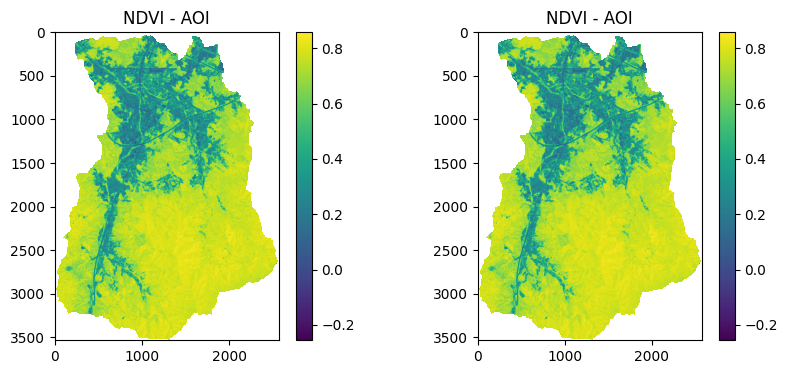

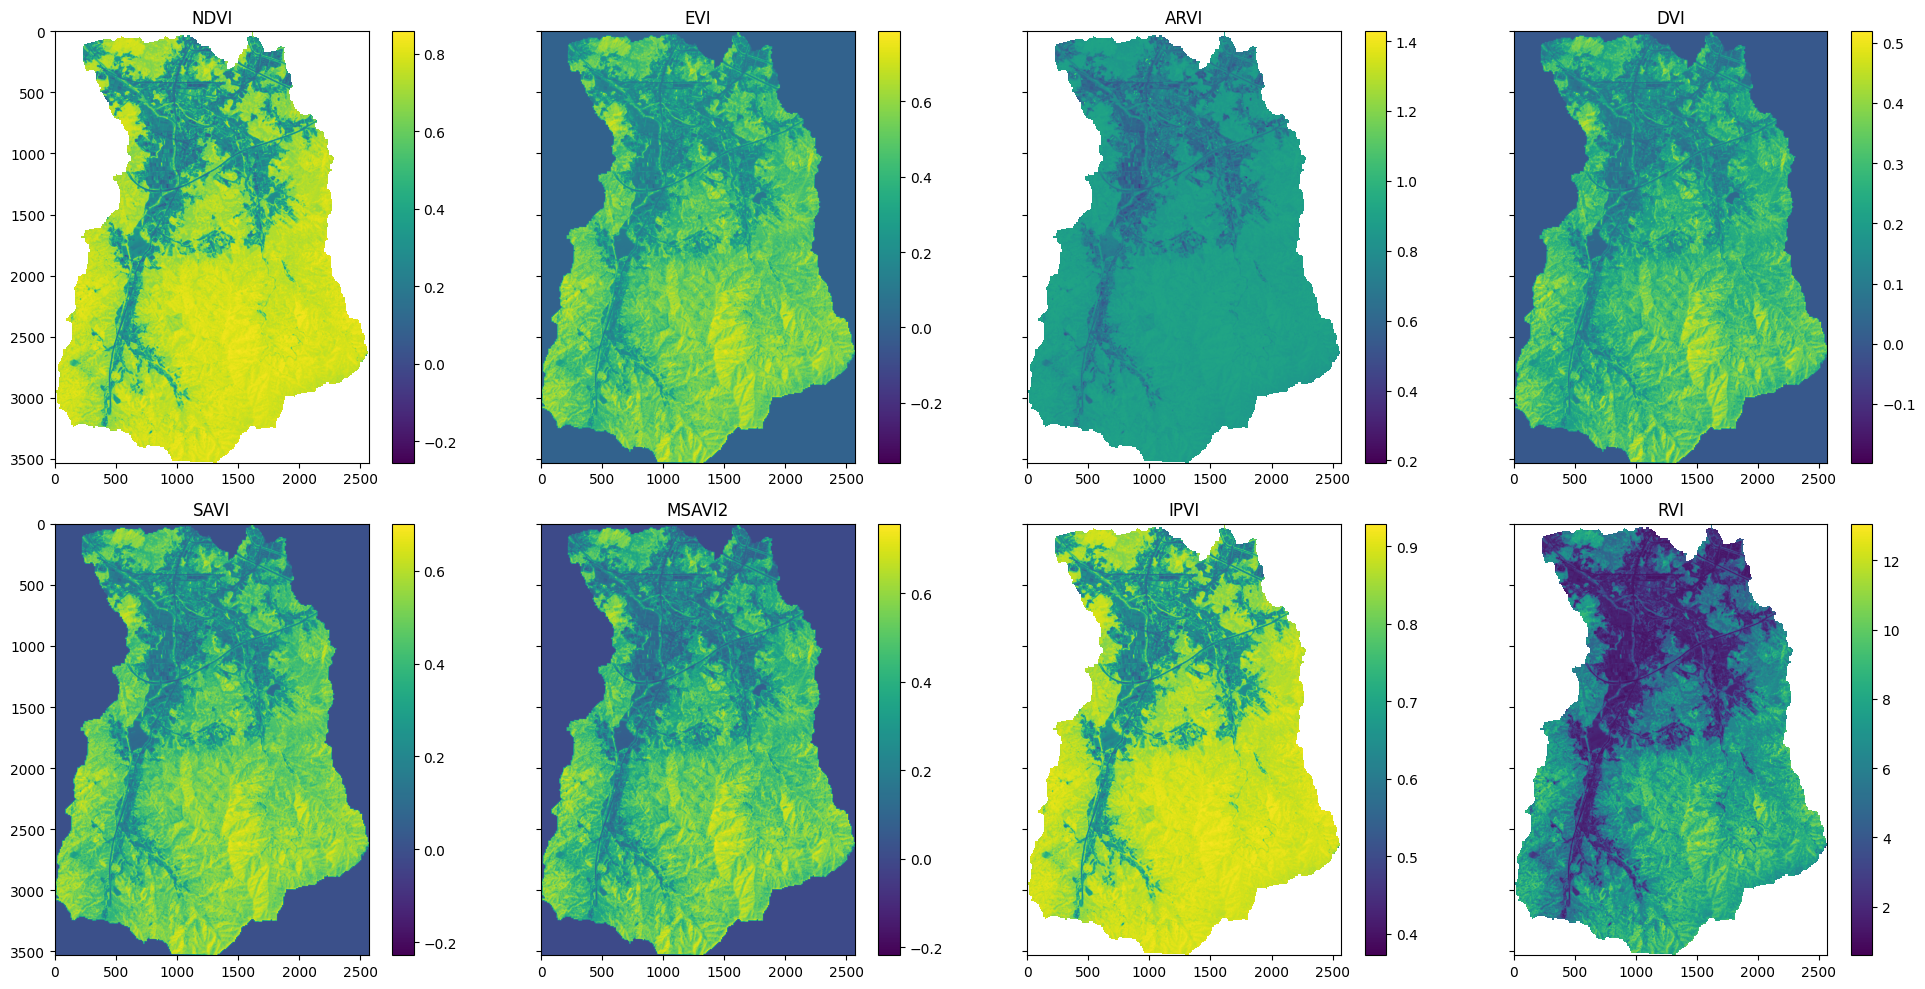

In [26]:
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

# Assuming that ndvi_list, evi_list, savi_list, msavi2_list, arvi_list, ipvi_list, dvi_list, and rvi_list have been calculated

# Set up the plotting
%matplotlib inline

# Visualize NDVI for large and small AOI (in this case, only one AOI is available)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(ndvi_list[0], cmap='viridis')
plt.title("NDVI - AOI")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(ndvi_list[0], cmap='viridis')
plt.title("NDVI - AOI")
plt.colorbar()

plt.show()

# Visualize other vegetation indices
f, axarr = plt.subplots(2, 4, figsize=(20, 10), sharey=True)

# NDVI
im = axarr[0, 0].imshow(ndvi_list[0], cmap='viridis')
axarr[0, 0].set_title("NDVI")
f.colorbar(im, ax=axarr[0, 0])

# EVI
im = axarr[0, 1].imshow(evi_list[0], cmap='viridis')
axarr[0, 1].set_title("EVI")
f.colorbar(im, ax=axarr[0, 1])

# ARVI
im = axarr[0, 2].imshow(arvi_list[0], cmap='viridis')
axarr[0, 2].set_title("ARVI")
f.colorbar(im, ax=axarr[0, 2])

# DVI
im = axarr[0, 3].imshow(dvi_list[0], cmap='viridis')
axarr[0, 3].set_title("DVI")
f.colorbar(im, ax=axarr[0, 3])

# SAVI
im = axarr[1, 0].imshow(savi_list[0], cmap='viridis')
axarr[1, 0].set_title("SAVI")
f.colorbar(im, ax=axarr[1, 0])

# MSAVI2
im = axarr[1, 1].imshow(msavi2_list[0], cmap='viridis')
axarr[1, 1].set_title("MSAVI2")
f.colorbar(im, ax=axarr[1, 1])

# IPVI
im = axarr[1, 2].imshow(ipvi_list[0], cmap='viridis')
axarr[1, 2].set_title("IPVI")
f.colorbar(im, ax=axarr[1, 2])

# RVI
im = axarr[1, 3].imshow(rvi_list[0], cmap='viridis')
axarr[1, 3].set_title("RVI")
f.colorbar(im, ax=axarr[1, 3])

plt.tight_layout()
plt.show()


#### Save the NDVI image
Finally we output these new pixel values to a new image file, making sure we mirror the GeoTIFF spatial metadata:

In [49]:
print(img_list[0].meta)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 397, 'height': 248, 'count': 4, 'crs': CRS.from_epsg(32722), 'transform': Affine(3.0, 0.0, 239181.0,
       0.0, -3.0, 9274158.0)}


In [32]:
 # Scale reflectance values by a factor of 10,000
scale_factor = 10000
ndvi_scaled = ndvi * scale_factor
evi_scaled = evi * scale_factor
savi_scaled = savi * scale_factor
msavi2_scaled = msavi2 * scale_factor
arvi_scaled = arvi * scale_factor
ipvi_scaled = ipvi * scale_factor
dvi_scaled = dvi * scale_factor
rvi_scaled = rvi * scale_factor

# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float64,
    count=1
)

# Create the files and write the scaled indices
indices = {
    'ndvi': ndvi_scaled,
    'evi': evi_scaled,
    'savi': savi_scaled,
    'msavi2': msavi2_scaled,
    'arvi': arvi_scaled,
    'ipvi': ipvi_scaled,
    'dvi': dvi_scaled,
    'rvi': rvi_scaled
    }

for name, data in indices.items():
        with rasterio.open(f"{Results_folder}{name}.tif", 'w', **kwargs) as dst:
            dst.write(data.astype(rasterio.float64), 1)

print("Indices calculated and saved successfully.")

Indices calculated and saved successfully.


In [33]:
# checking reflectance values
ndvi_min = np.nanmin(ndvi_list[0]);    ndvi_max = np.nanmax(ndvi_list[0])
print("NDVI values goes from: {} to {}".format(ndvi_min, ndvi_max))

NDVI values goes from: -0.2554903833037784 to 0.857726344452008
